# Boruta

* Boruta is a robust feature selection algorithm
* Algorithm uses two ideas:
  * Shadow features. Features compete with randomized versions of themselves
  * Binomial distribution. A series of *n* trials follows a binomial distribution
* There is no hard threshold between a refusal and acceptance of a feature
* There are 3 areas (see bell curve image below):
  * Area of refusal (red). Features are noise and are dropped
  * Area of irresolution (blue). Boruta is indecisive about features in this area
  * Area of acceptance (green). Boruta considers features here to be predictive and are kept

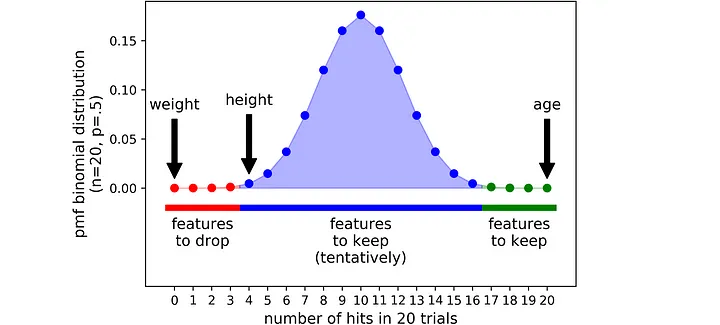

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor

#### Generate a toy dataset

*   Contains 3 features: age, height, and weight
*   One target variable: income
*   5 observations

#### Predict income

* Predict the income of a person knowing just their age, height, and weight
* In practice, our dataset would have hundreds or perhaps thousands of features
* Not practical to go through each feature manually and decide whether to retain the feature or not
* There may exist non-linear relationships and interactions in the dataset

In [2]:
X = pd.DataFrame({'age': [25, 32, 47, 51, 62],
                  'height': [182, 176, 174, 168, 181],
                  'weight': [75, 71, 78, 72, 86]})
y = pd.Series([20, 32, 45, 55, 61], name="income")

X

,age,height,weight
0,25,182,75
1,32,176,71
2,47,174,78
3,51,168,72
4,62,181,86


### Shadow features

* Take a copy of our original features X
* Randomly shuffle the features and call this new DataFrame X_shadow
* Attach X_shadow to X () column-wise
* The new appended DataFrame is called X_boruta and contains twice the number of columns of X

In [3]:
# Create X_shadow by randomly permuting each columm of X
np.random.seed(42)
X_shadow = X.apply(np.random.permutation)
X_shadow.columns = ['shadow' + feature for feature in X.columns]

# Create X_boruta by appending X_shadow to X
X_boruta = pd.concat([X, X_shadow], axis=1)

X_boruta  

,age,height,weight,shadowage,shadowheight,shadowweight
0,25,182,75,32,168,71
1,32,176,71,62,176,75
2,47,174,78,47,174,72
3,51,168,72,25,182,86
4,62,181,86,51,181,78


In [4]:
# Fit a Random Forest on X_boruta
rf = RandomForestRegressor(max_depth=5,
                           random_state=42)
rf.fit(X_boruta, y)

# Store feature importances
feature_importance_X = rf.feature_importances_[:len(X.columns)]
feature_importance_shadow = rf.feature_importances_[len(X.columns):]

# Determine features that were accepted (hits)
hits = feature_importance_X > feature_importance_shadow.max()

* For a single run, the feature importances were calculated
* Threshold of our randomly shuffled features is 21% (max of 10%, 21%, 15%)
* Only "age" exceeds this (28%)
* We cannot yet drop features as we only got this result after a single run

In [5]:
# Create a DataFrame of feature importances and whether the feature was accepted (hits)
importances = np.round(100 * rf.feature_importances_).astype(int)
hits_row = (np.append(hits, [False, False, False])) * 1
index_values = ['feature importance %', 'hits']

one_run = pd.DataFrame(data=[importances, hits_row],
                       index=index_values,
                       columns=X_boruta.columns)
one_run


,age,height,weight,shadowage,shadowheight,shadowweight
feature importance %,28,16,9,10,21,15
hits,1,0,0,0,0,0


### Binomial distribution

* A more robust way is to repeat the above process multiple times

In [6]:
# Initialize hits counter
hits = np.zeros((len(X.columns)))

# Repeat 20 times
for iter_ in range(20):
   # Make X_shadow by randomly permuting each column of X
   np.random.seed(iter_)
   X_shadow = X.apply(np.random.permutation)
   X_boruta = pd.concat([X, X_shadow], axis = 1)

   # Fit a Random Forest (suggest max_depth between 3 and 7)
   forest = RandomForestRegressor(max_depth = 5, random_state = 42)
   forest.fit(X_boruta, y)

   # Store feature importance
   feat_imp_X = forest.feature_importances_[:len(X.columns)]
   feat_imp_shadow = forest.feature_importances_[len(X.columns):]

   # Compute hits for this trial and add to counter
   hits += (feat_imp_X > feat_imp_shadow.max())

In [11]:
many_runs = pd.DataFrame(data=[hits.astype(int)],
                         index=['hits (in 20 trials)'],
                         columns=X.columns)
many_runs

,age,height,weight
hits (in 20 trials),18,5,0


In [9]:
X.columns

Index(['age', 'height', 'weight'], dtype='object')